In [1]:
import pandas as pd
from textdistance import hamming
from scipy.special import binom
from tqdm import tqdm
from itertools import combinations
from pathlib import Path
from collections import defaultdict

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

get_ipython().run_line_magic("matplotlib", "inline")
font = {"weight": "normal", "size": 14, "family": "DejaVu Sans"}
plt.rc("text", usetex=True)
plt.rc("font", **font)
mpl.rc("text.latex", preamble=r"\usepackage{amsmath}")
def rec_dd():
    return defaultdict(rec_dd)


In [2]:
benchmark_path = Path(
    "/home/gabrielathenes/Documents/study/HILARy/data_with_scripts/benchmark_on_partis_dataset/"
)
hilary = "hilary-full-1-2-0"


In [3]:
def pairwise_evaluation(df, partition, ground_truth="simulations"):
    TP = 0
    P = binom(df.groupby([ground_truth]).size(), 2).sum()
    TP_FP = binom(df.groupby([partition]).size(), 2).sum()
    for _, family in tqdm(df.groupby([ground_truth]), disable=True):
        for r1, r2 in combinations(family[partition], 2):
            if r1 == r2:
                TP += 1
    if TP_FP == 0:
        return 0.0, 1.0
    elif P == 0:
        return None, None
    return (
        TP / P,
        TP / TP_FP,
    )  # sensitivity, precision

def entropy(dfGrouped):
    fs = dfGrouped.size()
    fs = fs / sum(fs)
    return sum(fs * np.log2(fs))


def variation_of_info(df, result):
    VI = (
        entropy(df.groupby(["simulations"]))
        + entropy(df.groupby([result]))
        - 2 * entropy(df.groupby([result, "simulations"]))
    )
    return VI


In [4]:
metric_dict=rec_dd()
for seed in [0, 1, 2]:
    prec_list=[]
    sens_list=[]
    var_list=[]
    dataframe=pd.DataFrame()
    for model in ["simulations","partis","scoper",hilary]:
        print(seed,model)
        if model=="scoper":
            df = pd.read_csv(benchmark_path
                        / Path(
                            f"seed-{seed}/scratch-mute-freq-0.10/{model}/both_chains/partition.tsv"
                        ),
                sep="\t",
                index_col="sequence_id",
            )
        else :
            df = pd.read_csv(
                [
                    each
                    for each in (benchmark_path
                    / Path(
                        f"seed-{seed}/scratch-mute-freq-0.10/{model}/both_chains/"
                    )).glob(f"*igh.tsv*")
                ][0],
                sep="\t",
                index_col="sequence_id",
        )
        if model.startswith("hilary"):
            dataframe[model]=df["family"]
            dataframe["cdr3_length"]=df["cdr3_length"]
            dataframe[model + "_cdr3-based"] = df["cdr3_based_family"]
        else :
            dataframe[model]=df["clone_id"]

    grouped=dataframe.groupby("cdr3_length")
    for l,df_grouped in grouped :
        if l>45:continue
        for model in ["partis","scoper",hilary,f"{hilary}_cdr3-based"]:
            sensitivity,precision=pairwise_evaluation(df_grouped,model)
            varinfo = variation_of_info(df_grouped,model)
            metric_dict[model]["precision"][l][seed]=precision
            metric_dict[model]["sensitivity"][l][seed]=sensitivity
            metric_dict[model]["variation_of_info"][l][seed]=varinfo


0 simulations
0 partis
0 scoper
0 hilary-full-1-2-0
1 simulations
1 partis
1 scoper
1 hilary-full-1-2-0
2 simulations
2 partis
2 scoper
2 hilary-full-1-2-0


In [5]:
metric_dict_paired = rec_dd()
for seed in [0, 1, 2]:
    prec_list = []
    sens_list = []
    var_list = []
    for freq in ["0.01", "0.05", "0.10", "0.20", "0.30"]:
        dataframe = pd.DataFrame()
        for model in ["simulations", "partis", "scoper", hilary]:
            if model == "scoper":
                df = pd.read_csv(
                    [
                        each
                        for each in (
                            benchmark_path
                            / Path(
                                f"seed-{seed}/scratch-mute-freq-{freq}/{model}/both_chains/"
                            )
                        ).glob(f"*partition.tsv*")
                    ][0],
                    sep="\t",
                    index_col="sequence_id",
                )
            else:
                df = pd.read_csv(
                    [
                        each
                        for each in (
                            benchmark_path
                            / Path(
                                f"seed-{seed}/scratch-mute-freq-{freq}/{model}/both_chains/"
                            )
                        ).glob(f"*igh.tsv*")
                    ][0],
                    sep="\t",
                    index_col="sequence_id",
                )
            if model.startswith("hilary"):
                dataframe[model] = df["family"]
                dataframe["cdr3_length"] = df["cdr3_length"]
                dataframe[model + "_cdr3-based"] = df["cdr3_based_family"]
            else:
                dataframe[model] = df["clone_id"]

            sensitivity, precision = pairwise_evaluation(dataframe, model)
            varinfo = variation_of_info(dataframe, model)
            metric_dict_paired[model]["precision"][freq][seed] = precision
            metric_dict_paired[model]["sensitivity"][freq][seed] = sensitivity
            metric_dict_paired[model]["variation_of_info"][freq][seed] = varinfo
            if model.startswith("hilary"):
                model_cdr3 = model + "_cdr3-based"
                sensitivity, precision = pairwise_evaluation(dataframe, model_cdr3)
                varinfo = variation_of_info(dataframe, model_cdr3)
                metric_dict_paired[model_cdr3]["precision"][freq][seed] = precision
                metric_dict_paired[model_cdr3]["sensitivity"][freq][seed] = sensitivity
                metric_dict_paired[model_cdr3]["variation_of_info"][freq][
                    seed
                ] = varinfo


precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info
HILARy-full
precision
sensitivity
variation_of_info
precision
sensitivity
variation_of_info
scoper
hilary-full-1-2-0_cdr3-based
hilary-full-1-2-0
partis


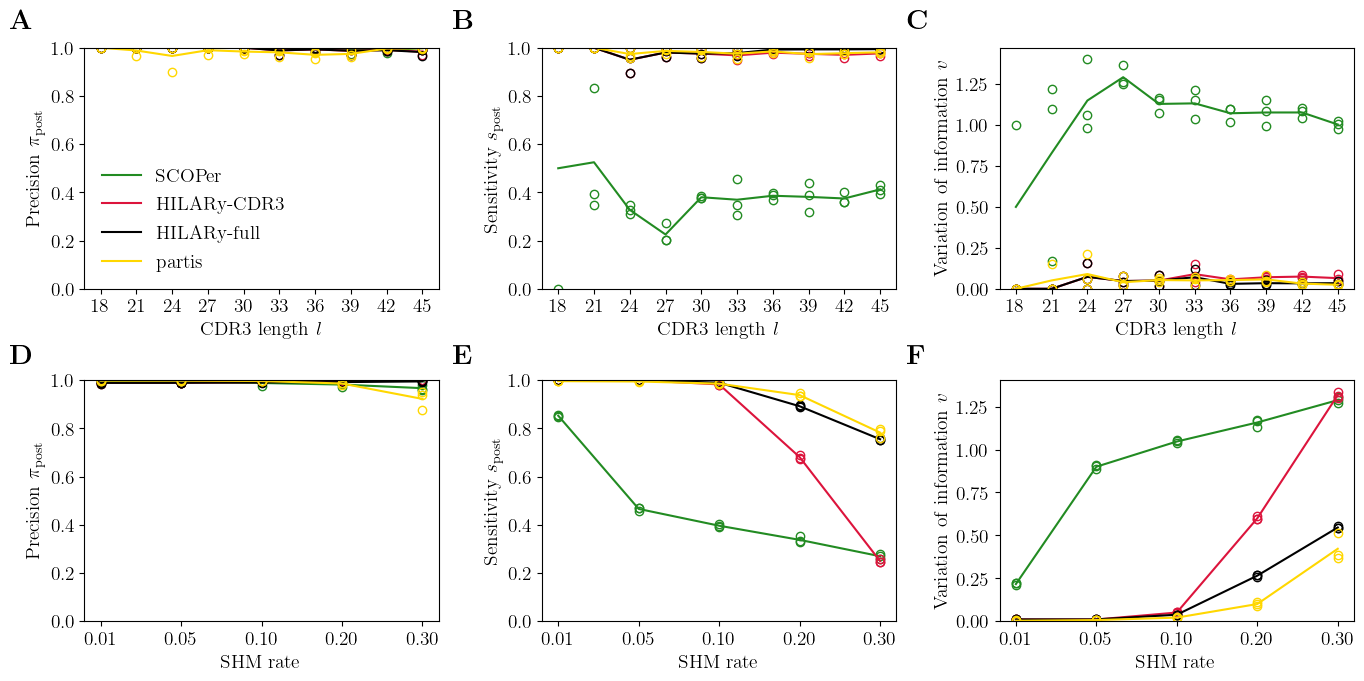

In [6]:
ls = np.arange(18, 45 + 3, 3)
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(231)
ax1.set_ylabel(r"Precision $\pi_{\rm post}$")
ax1.set_xlabel(r"CDR3 length $l$")
ax2 = fig.add_subplot(232)
ax2.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax2.set_xlabel(r"CDR3 length $l$")
ax3 = fig.add_subplot(233)
ax3.set_ylabel(r"Variation of information $v$")
ax3.set_xlabel(r"CDR3 length $l$")

colors = {
    "scoper": "forestgreen",
    f"{hilary}_cdr3-based": "crimson",
    hilary: "k",
    "partis": "gold",
}
axes = [ax1, ax2, ax3]

for model in colors:
    if model == hilary:
        label = "HILARy-full"
        print(label)
    elif model == f"{hilary}_cdr3-based":
        label = "HILARy-CDR3"
    elif model == "partis":
        label = "partis"
    elif model == "alignment_free":
        label = "Alignment-free"
    elif model == "scoper":
        label = "SCOPer"
    for i, metric in enumerate(metric_dict[model]):
        print(metric)
        for l in metric_dict[model][metric]:
            y = list(metric_dict[model][metric][l].values())
            x = [l] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for length in metric_dict[model][metric]:
            lengths.append(length)
            averages.append(np.mean(list(metric_dict[model][metric][length].values())))
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )


ax1.set_xticks(ls)
ax1.set_xticklabels(ls)
ax2.set_xticks(ls)
ax2.set_xticklabels(ls)
ax3.set_xticks(ls)
ax3.set_xticklabels(ls)
ax1.legend(frameon=False)
ax1.set_ylim(bottom=0,top=1)
ax2.set_ylim(bottom=0, top=1)
ax3.set_ylim(bottom=0)

"-------------------------------------------------------------------------------------"

ls = [0.01, 0.05, 0.10, 0.20, 0.30]
ax4 = fig.add_subplot(234)
ax4.set_ylabel(r"Precision $\pi_{\rm post}$")
ax4.set_xlabel(r"SHM rate")
ax5 = fig.add_subplot(235)
ax5.set_ylabel(r"Sensitivity $s_{\rm post}$")
ax5.set_xlabel(r"SHM rate")
ax6 = fig.add_subplot(236)
ax6.set_ylabel(r"Variation of information $v$")
ax6.set_xlabel(r"SHM rate")

colors = {
    "scoper": "forestgreen",
    f"{hilary}_cdr3-based": "crimson",
    hilary: "k",
    "partis": "gold",
}
axes = [ax4, ax5, ax6]

for model in colors:
    if model == hilary:
        label = "HILARy-full"
    elif model == hilary:
        label = "HILARy-CDR3"
    elif model == "partis":
        label = "partis"
    elif model == "alignment_free":
        label = "Alignment-free"
    elif model == "scoper":
        label = "SCOPer"
    print(model)
    for i, metric in enumerate(metric_dict_paired[model]):
        for freq in metric_dict_paired[model][metric]:
            y = list(metric_dict_paired[model][metric][freq].values())
            x = [freq] * len(y)
            axes[i].plot(
                x,
                y,
                "o",
                fillstyle="none",
                color=colors[model],
            )
        lengths = []
        averages = []
        for freq in metric_dict_paired[model][metric]:
            lengths.append(freq)
            averages.append(
                np.mean(list(metric_dict_paired[model][metric][freq].values()))
            )
        axes[i].plot(
            lengths,
            averages,
            color=colors[model],
            label=label,
        )

ax1.set_ylim(bottom=0, top=1)
ax2.set_ylim(bottom=0, top=1)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0, top=1)
ax5.set_ylim(bottom=0, top=1)
ax6.set_ylim(bottom=0)

plt.tight_layout(pad=1.8)
plt.text(-12.5, 3.45, r"\bf{A}", rotation=0, wrap=True, fontsize=20)
plt.text(-7, 3.45, r"\bf{B}", rotation=0, wrap=True, fontsize=20)
plt.text(-1.35, 3.45, r"\bf{C}", rotation=0, wrap=True, fontsize=20)
plt.text(-12.5, 1.5, r"\bf{D}", rotation=0, wrap=True, fontsize=20)
plt.text(-7, 1.5, r"\bf{E}", rotation=0, wrap=True, fontsize=20)
plt.text(-1.35, 1.5, r"\bf{F}", rotation=0, wrap=True, fontsize=20)


plt.savefig(
    "/home/gabrielathenes/Dropbox/Natanael_lineages_inference/revisions_2024_06_25/figures/figure6.pdf",
)
plt.show()
